# Analysis of BTC-USD for the 2017-2018 period

In [1]:
import quandl
import warnings
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 20
np.random.seed = 101

In [3]:
btc = quandl.get('BCHARTS/BITSTAMPUSD')
btc = btc['2017-01-01':]

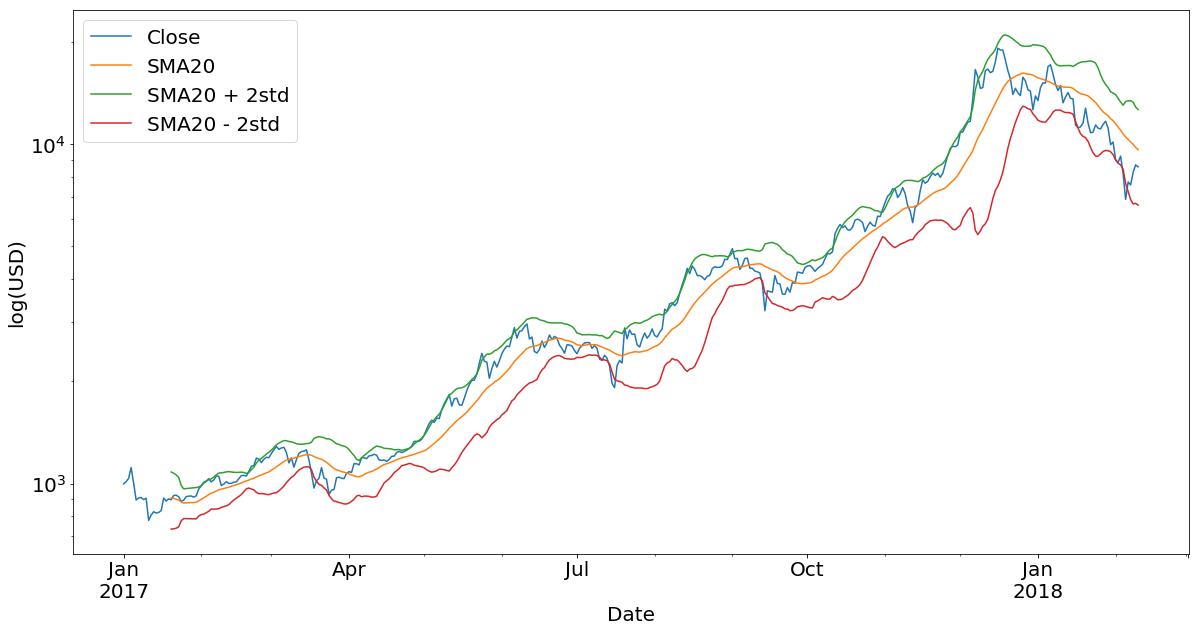

In [5]:
btc.replace(0, np.nan, inplace=True)

btc['SMA20'] = btc['Close'].rolling(20).mean()
btc['SMA20 + 2std'] = btc['SMA20'] + 2 * btc['Close'].rolling(20).std()
btc['SMA20 - 2std'] = btc['SMA20'] - 2 * btc['Close'].rolling(20).std()

btc[[
    'Close',
    'SMA20',
    'SMA20 + 2std',
    'SMA20 - 2std',
]].plot(
    figsize=(20, 10),
    logy=True
)

plt.ylabel('log(USD)')
plt.legend();

In [5]:
DISTRIBUTIONS = [        
    stats.alpha,
    stats.anglit,
    stats.arcsine,
    stats.beta,
    stats.betaprime,
    stats.bradford,
    stats.burr,
    stats.cauchy,
    stats.chi,
    stats.chi2,
    stats.cosine,
    stats.dgamma,
    stats.dweibull,
    stats.erlang,
    stats.expon,
    stats.exponnorm,
    stats.exponweib,
    stats.exponpow,
    stats.f,
    stats.fatiguelife,
    stats.fisk,
    stats.foldcauchy,
    stats.foldnorm,
    stats.frechet_r,
    stats.frechet_l,
    stats.genlogistic,
    stats.genpareto,
    stats.gennorm,
    stats.genexpon,
    stats.genextreme,
    stats.gausshyper,
    stats.gamma,
    stats.gengamma,
    stats.genhalflogistic,
    stats.gilbrat,
    stats.gompertz,
    stats.gumbel_r,
    stats.gumbel_l,
    stats.halfcauchy,
    stats.halflogistic,
    stats.halfnorm,
    stats.halfgennorm,
    stats.hypsecant,
    stats.invgamma,
    stats.invgauss,
    stats.invweibull,
    stats.johnsonsb,
    stats.johnsonsu,
    stats.ksone,
    stats.kstwobign,
    stats.laplace,
    stats.levy,
    stats.levy_l,
    stats.levy_stable,
    stats.logistic,
    stats.loggamma,
    stats.loglaplace,
    stats.lognorm,
    stats.lomax,
    stats.maxwell,
    stats.mielke,
    stats.nakagami,
    stats.ncx2,
    stats.ncf,
    stats.nct,
    stats.norm,
    stats.pareto,
    stats.pearson3,
    stats.powerlaw,
    stats.powerlognorm,
    stats.powernorm,
    stats.rdist,
    stats.reciprocal,
    stats.rayleigh,
    stats.rice,
    stats.recipinvgauss,
    stats.semicircular,
    stats.t,
    stats.triang,
    stats.truncexpon,
    stats.truncnorm,
    stats.tukeylambda,
    stats.uniform,
    stats.vonmises,
    stats.vonmises_line,
    stats.wald,
    stats.weibull_min,
    stats.weibull_max,
    stats.wrapcauchy
]

In [6]:
btc['Daily Return'] = btc['Close'].pct_change(1)
data = btc['Daily Return'].dropna()

hist, bin_edges = np.histogram(data, bins=200, density=True)
bin_edges = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0

best_distribution = stats.norm
best_params = [0, 1]
best_score = np.inf

for distribution in DISTRIBUTIONS:
    try:
        params = distribution.fit(data)
        args, location, scale = params[:-2], params[-2], params[-1]
        pdf = distribution.pdf(bin_edges, loc=location, scale=scale, *args)
        score = np.sum(np.power(hist - pdf, 2)) / len(hist)

        if score < best_score:
            best_distribution = distribution
            best_params = params
            best_score = score
    except BaseException:
        pass

In [7]:
args, location, scale = best_params[:-2], best_params[-2], best_params[-1]

start = best_distribution.ppf(0.01, loc=location, scale=scale, *args)
end = best_distribution.ppf(0.99, loc=location, scale=scale, *args)
bin_edges = np.linspace(start, end, 1e4)

fitted_pdf = pd.Series(
    best_distribution.pdf(bin_edges, loc=location, scale=scale, *args),
    bin_edges
)

mu = best_distribution.mean(*args, loc=location, scale=scale)
sigma = best_distribution.std(*args, loc=location, scale=scale)

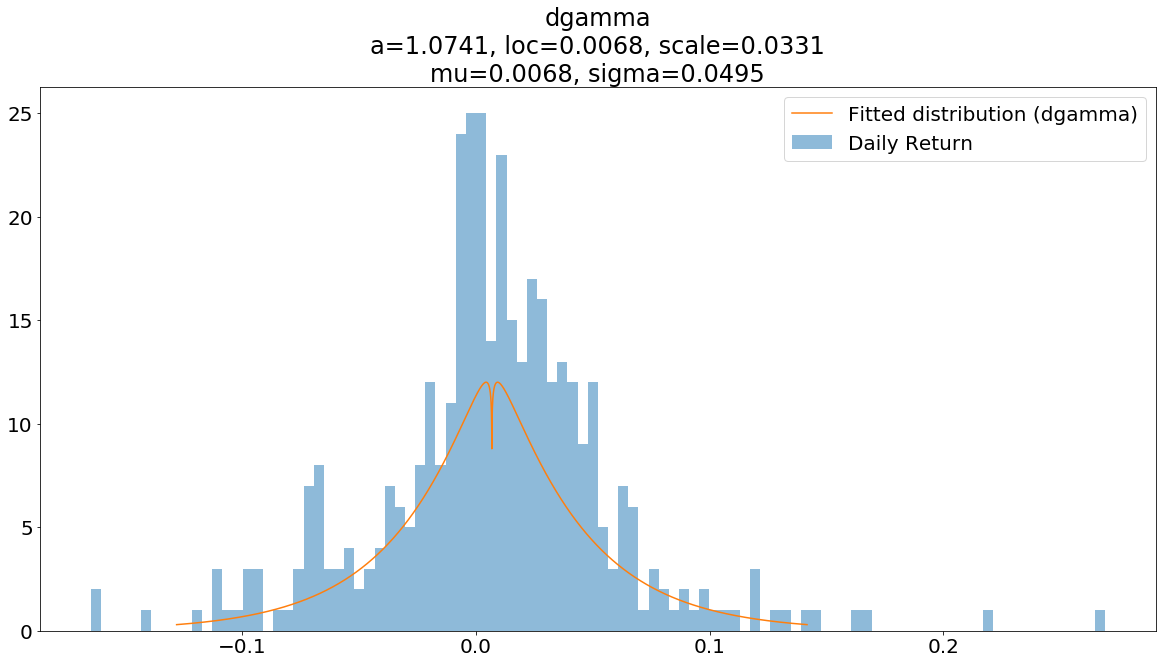

In [8]:
btc['Daily Return'].hist(
    bins=100,
    figsize=(20, 10),
    alpha=0.5,
    label='Daily Return'
)

fitted_pdf.plot(
    label='Fitted distribution (%s)' % best_distribution.name
)

param_names = [best_distribution.shapes] + ['loc', 'scale'] if best_distribution.shapes else ['loc', 'scale']
title = ', '.join(['%s=%.4f' % (name, val) for name, val in zip(param_names, best_params)])
title = '%s\n%s\nmu=%.4f, sigma=%.4f' % (best_distribution.name, title, mu, sigma)

plt.title(title)
plt.legend();

In [9]:
daily_volatility = btc['Daily Return'].dropna().std()
annual_volatility = daily_volatility * np.sqrt(365)
daily_drift = btc['Daily Return'].dropna().mean()
annual_drift= daily_drift * 365
mean_drift = daily_drift - 0.5 * daily_volatility ** 2

btc_statistics = pd.DataFrame(
    [
        daily_volatility,
        annual_volatility,
        daily_drift,
        annual_drift,
        mean_drift
    ],
    [
        'Volatility (Daily)',
        'Volatility (Annual)',
        'Drift (Daily)',
        'Drift (Annual)',
        'Drift (Mean)'
    ]
)

btc_statistics.transpose()

,Volatility (Daily),Volatility (Annual),Drift (Daily),Drift (Annual),Drift (Mean)
0,0.050676,0.968161,0.007497,2.736374,0.006213
